# Pronostico de gas
Pronostico de gas para Punta Arenas

## DESAFÍO

Como puede ser de su conocimiento, para la ciudad de Punta Arenas, la disponibilidad de GAS es crucial.
Por lo anterior, la autoridad ha solicitado construir un modelo estadístico que permita obtener proyecciones del consumo diario con base en la información disponible (Observación: el interés primordial es obtener predicciones diarias de 1 a 7 días, además, semanales de 1-5 semanas, y con el objetivo de negociar y prever situaciones particulares, obtener predicciones mensuales de 1 a 3 meses).

Para lo anterior se cuenta con la información del consumo de gas natural entre el 20 de octubre de 1995 y 31 de diciembre de 2002.

El objetivo consiste en realizar un modelo con enfoque Machine Learning para poder obtener las predicciones solicitadas. Además, se solicita entregar cualquier otro análisis que el postulante considere pertinente para llegar al modelo (o modelos) final. Además, se deben mostrar KPIs técnicos para poder evaluar la performance del modelo. 

## Librerias
### Usadas durante todo el análisis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
sns.set()

### Usadas para EDA
Librerías usadas durante el análisis exploratorio  (Exploratory data analysis)

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose #Series de tiempo
from statsmodels.graphics.tsaplots import plot_acf #Autocorrelación
from statsmodels.graphics.tsaplots import plot_pacf #Autocorrelación parcial
import statsmodels.api as sm #Regresion lineal

## Análisis descriptivo de los datos

In [3]:
datos=pd.read_csv("Consumo Gas Región Magallanes.csv", sep=';', encoding='Windows-1252')

In [4]:
datos.head()

,Consumo,Dia,Mes,Año,DiaSemana,Feriado
0,716,20,10,1995,Viernes,0
1,605,21,10,1995,Sábado,1
2,555,22,10,1995,Domingo,1
3,680,23,10,1995,Lunes,0
4,713,24,10,1995,Martes,0


In [5]:
datos["Fecha"] = datos["Año"].map(str) +'/'+ datos["Mes"].map(str) +'/'+ datos["Dia"].map(str);
datos["Fecha"] = pd.to_datetime(datos['Fecha']);
Day=pd.Series(datos.Consumo.values, index=datos["Fecha"].values);

In [6]:
datos.dtypes.to_frame()

,0
Consumo,int64
Dia,int64
Mes,int64
Año,int64
DiaSemana,object
Feriado,int64
Fecha,datetime64[ns]


In [7]:
datos.describe()

,Consumo,Dia,Mes,Año,Feriado
count,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000
mean,725.563118,15.776046,6.653992,1998.888213,0.198099
std,171.770851,8.810094,3.491289,2.079180,0.398643
min,333.000000,1.000000,1.000000,1995.000000,0.000000
25%,579.000000,8.000000,4.000000,1997.000000,0.000000
50%,715.000000,16.000000,7.000000,1999.000000,0.000000
75%,876.000000,23.000000,10.000000,2001.000000,0.000000
max,1222.000000,31.000000,12.000000,2002.000000,1.000000


Algunos análisis básicos obtenidos de estos datos:
-  Es un dataset sin faltantes, con lo cual no hay que aplicar tratamiento a los mismos.
-  El periodo cubre del año 1995 al 2002
-  Los consumos de gas oscilan entre 333 a 1222

### Comportamiento de la variable consumo

Analizaremos el comportamiento de la variable de interes Consumo de gas para ello es importante analizarla en las tres frecuencias solicitadas en el enunciado (diaría, mensual y anual).

In [8]:
Week=Day.resample('W-Thu').sum()
Month=datos.groupby(by=['Año', 'Mes'])['Consumo'].sum()
Year=datos.groupby(by=['Año'])['Consumo'].sum()
def index2time(x):
    x=x.replace(', ','-')
    x=x.replace('(','')
    x=x.replace(')','')
    if len(x)==6:
        x=x[:5]+'0'+x[5:]
    x=np.datetime64(x,'D')
    return x
arr=Month.index.map(str)
arr=arr.map(index2time)
Month=pd.Series(Month.values, index=arr)
Year=pd.Series(Year.values, index=Year.index.map(str).map(np.datetime64))


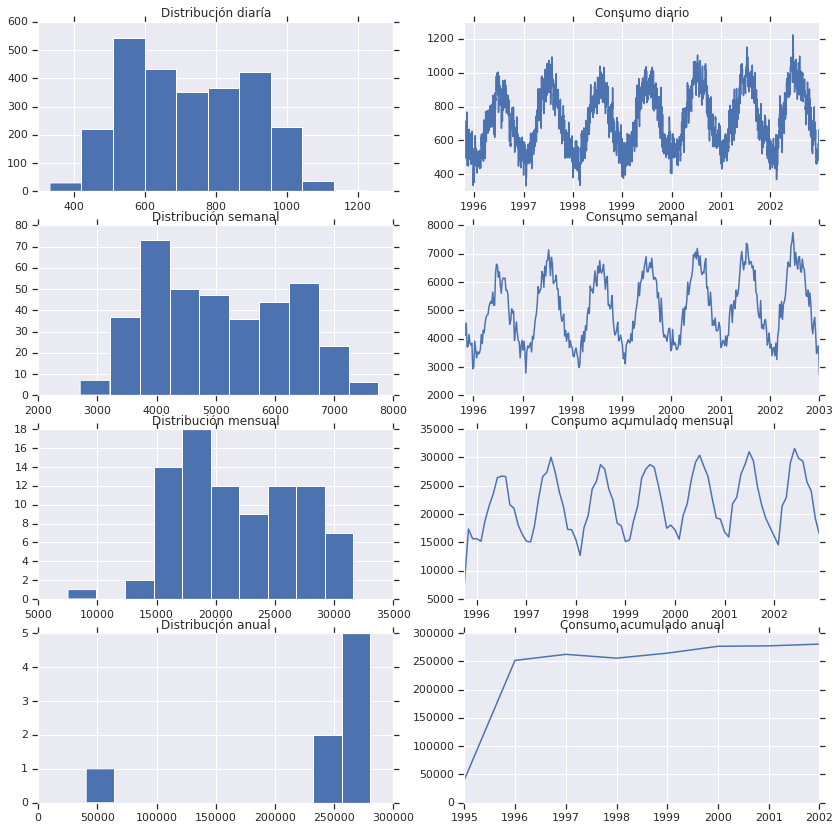

In [9]:
fig = plt.figure(figsize=(14,14))

plt.subplot2grid((4,2),(0,0))
plt.hist(Day.values);
plt.title('Distribución diaría')

plt.subplot2grid((4,2),(0,1))
plt.plot(Day);
plt.title('Consumo diario')

plt.subplot2grid((4,2),(1,0))
plt.hist(Week.values);
plt.title('Distribución semanal')

plt.subplot2grid((4,2),(1,1))
plt.plot(Week);
plt.title('Consumo semanal')

plt.subplot2grid((4,2),(2,0))
plt.hist(Month.values);
plt.title('Distribución mensual')

plt.subplot2grid((4,2),(2,1))
plt.plot(Month.index,Month.values);
plt.title('Consumo acumulado mensual')

plt.subplot2grid((4,2),(3,0))
plt.hist(Year.values);
plt.title('Distribución anual')

plt.subplot2grid((4,2),(3,1))
plt.plot(Year.index,Year.values);
plt.title('Consumo acumulado anual');

De las gráficas se puede observar que:
1. Presenta periodicidad mensual en las gráficas consumos diarios y mensuales.
2. Esposible que los primeros meses del año 1995 presenten datos incompletos, es necesario analizarlos para determinar si son considerados como datos atípicos.
3. Es posible que el año 1995 este incompleto (para la serie anual es cosiderado como dato atípico)

In [10]:
datos.loc[datos['Año'] == 1995].groupby(['Año','Mes'])['Consumo'].count().to_frame()

Consumo
Año  Mes         
1995 10        12
     11        30
     12        31

En efecto solo existen datos desde los ultimos 12 días del mes de octubre, para el análisis mensual estos datos deben ser eliminados por comportarse como átipicos.

In [11]:
def plot_ts(ts):
    decomposition = seasonal_decompose(ts)
    fig=plt.figure(figsize=(14,14))

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot2grid((4,1),(0,0))
    plt.plot(ts, label='Original');

    plt.subplot2grid((4,1),(1,0))
    plt.plot(trend, label='Tendencia');

    plt.subplot2grid((4,1),(2,0))
    plt.plot(seasonal, label='Estacionalidad');

    plt.subplot2grid((4,1),(3,0))
    plt.plot(residual, label='Residuos');

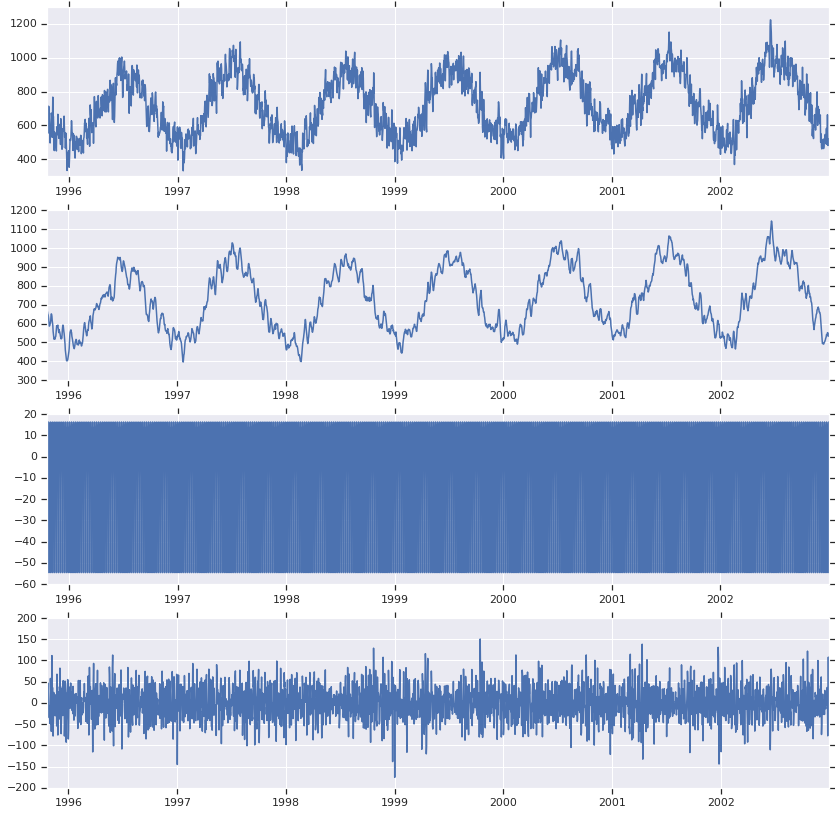

In [12]:
plot_ts(Day)

Como se puede observar en las gráficas anteriores, al aplicar la descomposicion de la serie de tiempo sobre los datos diarios no se obtiene información relevante. Si fuese un análisis estadístico, se recomendaría eliminar la tendencia en los datos o hacer una transformación en los mismos.

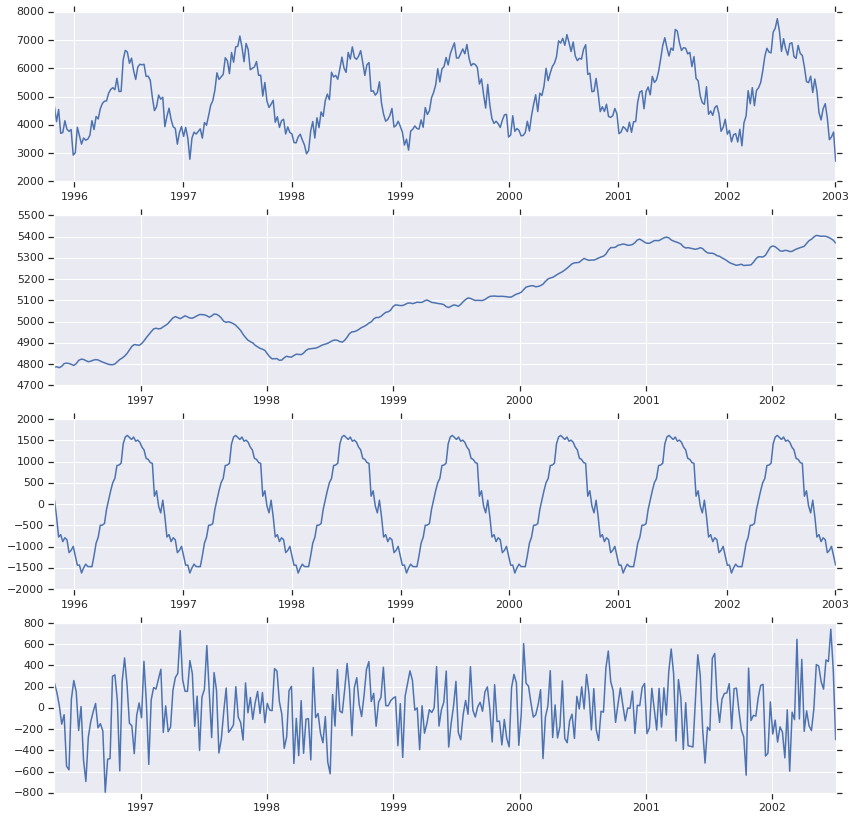

In [13]:
plot_ts(Week)

El consumo presenta un comportamiento estacional, realacionado como se esperaba a las estaciones: invierno con máximo cosumo y verano el minimo.

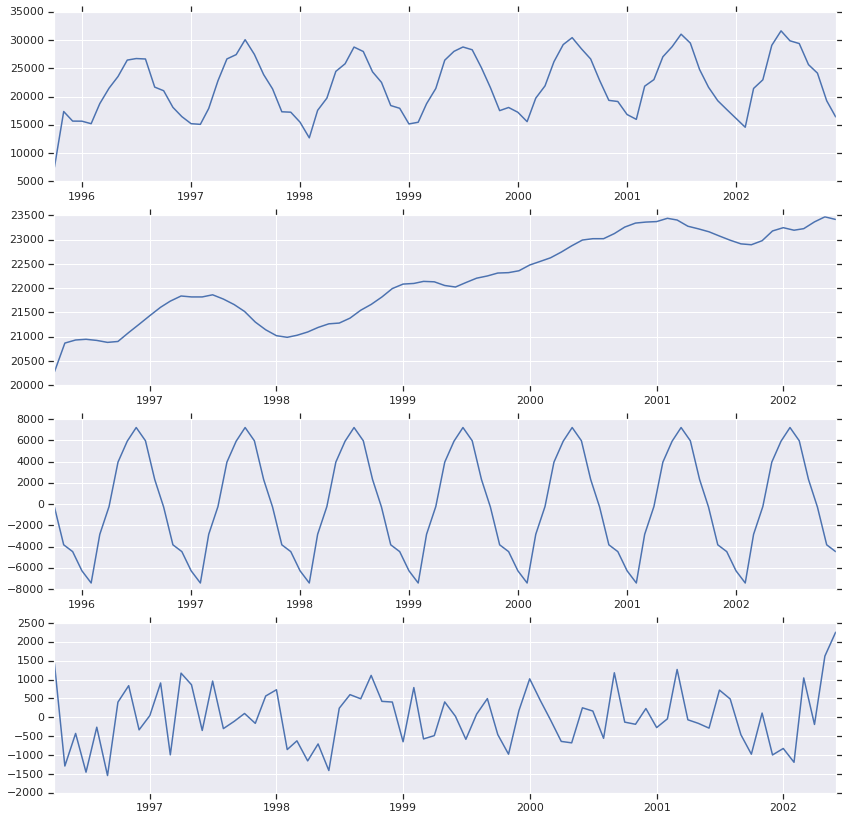

In [14]:
plot_ts(Month)

Como se esperaba, en la descomposición de la serie mensual se observa el ciclo anual. Además de una clara tendencia de crecimiento en los datos, casi lineal con los cambios de nivel del año 1997 y 2001. Es conveniente evaluar otras variables no incluidas en el dataset por ejemplo: Temperatura media mensual, el fenomeno del Niño y los precios del gas.

/usr/local/lib/python3.5/dist-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


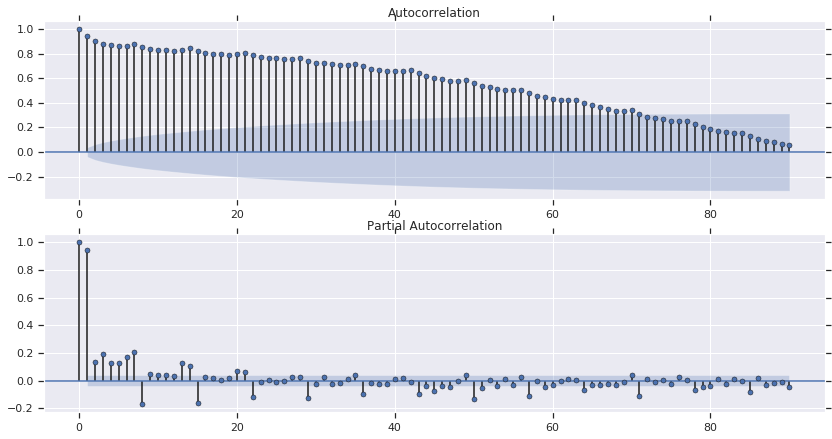

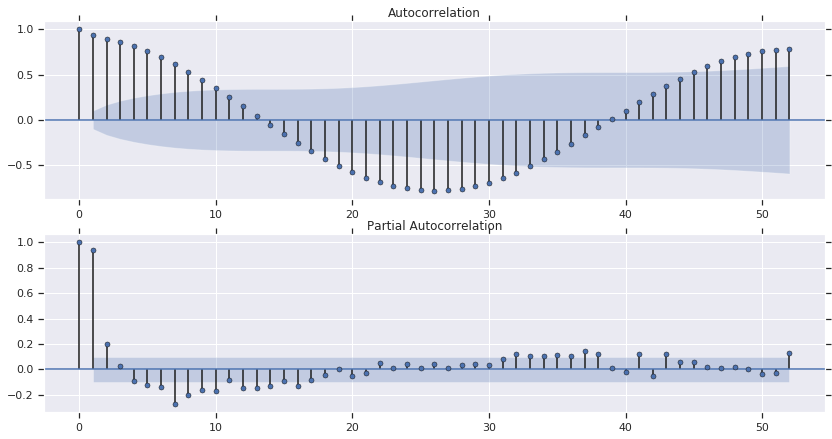

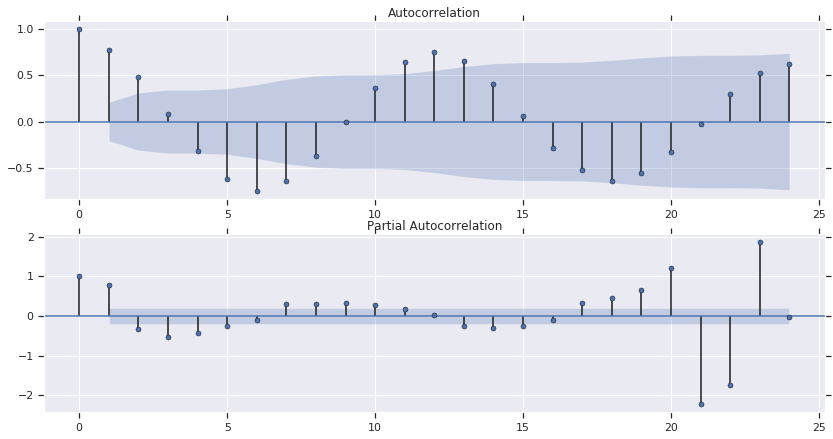

In [15]:
def autocorrelation(ts, lag):
    fig, ax = plt.subplots(2,1, figsize=(14, 7));
    plot_acf(ts.values, lags=lag, ax=ax[0]);
    plot_pacf(ts.values, lags=lag, ax=ax[1]);
autocorrelation(Day, 90)
autocorrelation(Week, 52)
autocorrelation(Month, 24)

Serie diaría
1. Para la serie diaria, el valor más significativo es el día anterior al día 0.
2. El resto de días de la semana previa (d-7) son significativos pero muy poco con respecto al día anterior.
3. Para el modelamiento de esta serie se probara su eficacia con solo el día anterior, si el modelo no presenta un ajuste adecuado se pasará a usar los otros días de la semana

Serie semanal
1. En esta serie solo es significativa la relación con la semana anterior

Serie mensual
1. Es significativa la relación con el mes anterior
2. Es significativa la relación con los meses 21,22 y 23. Estos no se usaran para el modelamiento puesto que se perderían 2 años de los 7 disponibles (84 meses en total). Dejando una serie muy corta para entrenar con altas posibilidades de sobre entrenamiento
3. De no haber ajuste con solo el mes anterior, se aplicarán los rezagos 21, 22 y 23

### Comportamiento de la variable consumo con respecto al resto
#### Sin eliminación de la tendencia

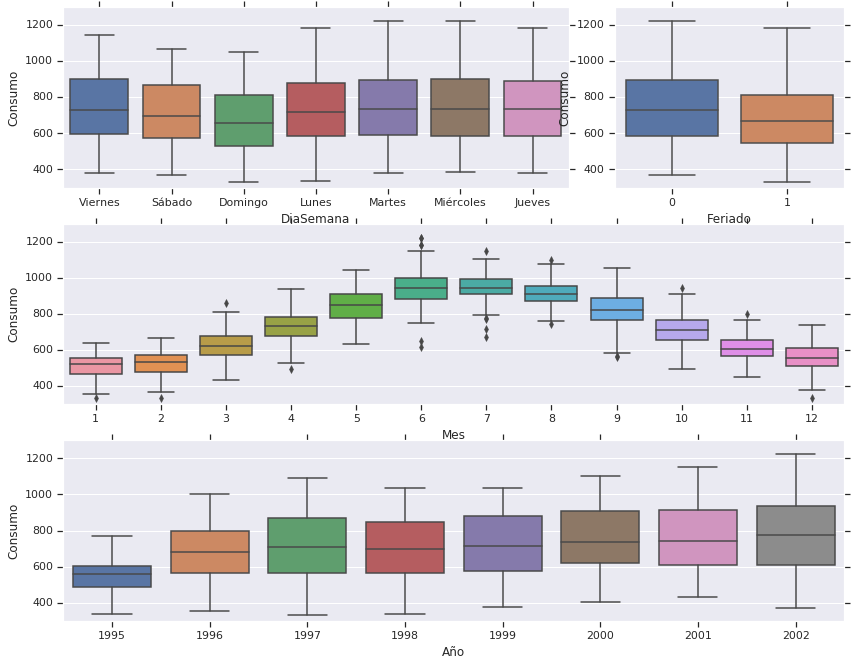

In [16]:
fig = plt.figure(figsize=(14,11))
plt.subplot2grid((3,3),(0,0),colspan=2)
sns.boxplot(x=datos['DiaSemana'], y=datos["Consumo"]);
plt.subplot2grid((3,3),(0,2))
sns.boxplot(x=datos['Feriado'], y=datos["Consumo"]);
plt.subplot2grid((3,3),(1,0), colspan=3)
sns.boxplot(x=datos['Mes'], y=datos["Consumo"]);
plt.subplot2grid((3,3),(2,0), colspan=3)
sns.boxplot(x=datos['Año'], y=datos["Consumo"]);

De las gráficas se puede entender que:
1. Existe una clara evidencia que los días feriados el consumo de Gas es reducido. 
2. La media del día domingo es menor que el resto de días de la semana
3. La media del día sábado es ligeramente menor que lunes a viernes
4. Salvo 1995, el comportamiento anual tiene un comportamiento similar con aumentos de los valores máximo de consumo
5. Los meses de invierno son los de mayor consumo y los de verano de menor consumo de gas, como se esperaba

Para el modelo es importante:
- Diferenciar los sábados y domingos del resto de días de la semana
- Si el día es feriado o no. Para la serie mensual y semanal cuantos feriados hubo.
- Diferenciar el mes y año

#### Correlaciones

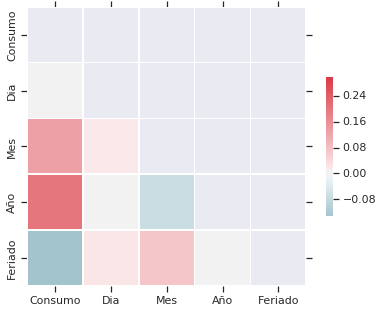

In [17]:
# Compute the correlation matrix
corr = datos.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});


De la matriz de correlaciones podemos concluir
1. No existe correlación fuertemente lineal entre ninguna de las variables, al no pasar +0.24
2. Es más fuerte la relación con las variables de mes y año con el consumo
3. Contradiciendo la evidencia gráfica, la variable Feriado no esta correlacionada, esto se debe a que solo análizamos relación lineal; existen más tipos de relaciones.

### Temperatura punta arenas
Se descargo el historico mensual de las temperaturas  de Punta Arenas de la página 
https://www.meteored.cl/tiempo-en_Punta+Arenas-America+Sur-Chile-Magallanes+y+de+la+Antartica+Chilena-SCCI-sactual-18570.html

In [67]:
temp=pd.read_csv('temperaturas.csv', encoding='UTF-8', sep=";")
temp.columns=['Año', 'Mes', 'Tmedia', 'Tmax', 'Tmin', 'Viento', 'Vmax', 'Presion', 'Lluvia']
temp.Tmax=temp['Tmax'].map(lambda x:int(x[:-3]))
temp.Tmin=temp['Tmin'].map(lambda x:int(x[:-3]))
temp.Tmedia=temp['Tmedia'].map(lambda x:int(x[:-3]))
temp.Viento=temp['Viento'].map(lambda x:float(x[:-5]))
temp.Vmax=temp['Vmax'].map(lambda x:float(x[:-5]))
temp.Presion=temp['Presion'].map(lambda x:float(x[:-4]))
temp.Lluvia=temp['Lluvia'].map(lambda x:float(x[:-3]))

temp['date']=pd.date_range(start='1/1/1995', end='12/31/2002', freq='M')
temp['Fecha'] = pd.to_datetime(temp['date'])
temp = temp.set_index('Fecha')
temp.drop(['date'], axis=1, inplace=True)
temp.head()

,Año,Mes,Tmedia,Tmax,Tmin,Viento,Vmax,Presion,Lluvia
Fecha,,,,,,,,,
1995-01-31,1995,1,11,22,3,22.5,92.4,1004.4,26.9
1995-02-28,1995,2,11,23,1,23.7,114.8,1008.9,48.1
1995-03-31,1995,3,8,20,-3,25.6,92.4,1002.9,62.9
1995-04-30,1995,4,8,17,-3,20.7,85.2,1002.1,31.7
1995-05-31,1995,5,5,13,-3,20.6,92.4,1003.3,49.0


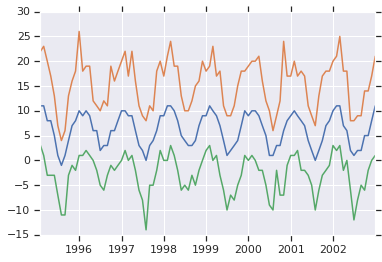

In [19]:
plt.plot(temp[['Tmedia', 'Tmax', 'Tmin']]);

Se observa que el invierno de 1997 es el más fuerte de la serie, lo cual se ve reflejado en los consumos de gas. Estas relaciones se pueden validar al realizar la matriz de correlaciones.

In [68]:
temp=temp.loc[temp.index > pd.to_datetime(dt.date(1995,10,1))]
temp['Consumo']=Month.values
temp=temp.loc[temp.index > pd.to_datetime(dt.date(1995,11,1))]

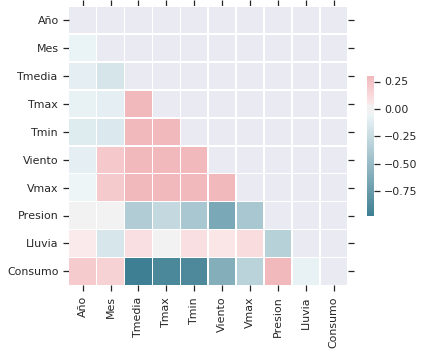

In [21]:
# Compute the correlation matrix
corr = temp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Como se esperaba, los datos climatologicos como: temperatura (media, minima y máxima), velocidad del viento y presion, tienen fuerte relación lineal con los consumos de gas. Para validar si son variables descriptivas del consumo de gas, aplico una regresión lineal de estas variables contra el consumo del mismo mes.

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


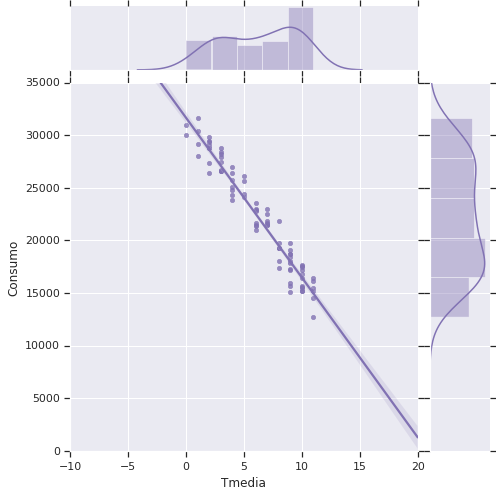

In [22]:
sns.jointplot("Tmedia", "Consumo", data=temp, kind="reg",
                  xlim=(-10, 20), ylim=(0, 35000), color="m", height=7);

In [23]:
reg_Month=sm.OLS(temp["Consumo"],temp[["Tmedia","Tmin","Viento", "Presion"]], missing='drop').fit()
print(reg_Month.summary())

                            OLS Regression Results                            
Dep. Variable:                Consumo   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     7861.
Date:                Sun, 11 Nov 2018   Prob (F-statistic):          4.40e-105
Time:                        17:51:49   Log-Likelihood:                -728.54
No. Observations:                  86   AIC:                             1465.
Df Residuals:                      82   BIC:                             1475.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Tmedia     -1475.7051     98.045    -15.051      0.0

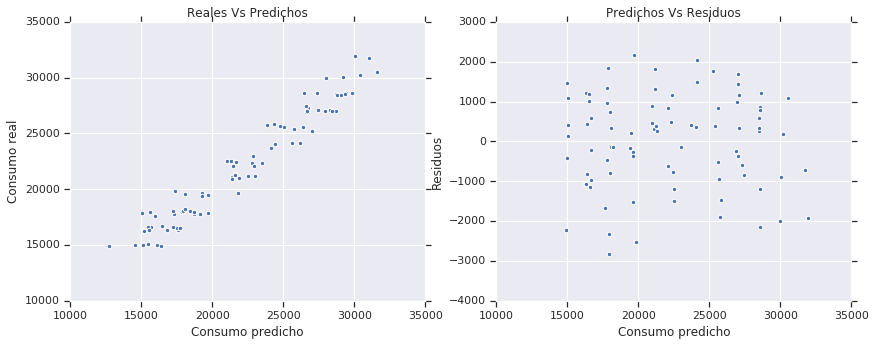

In [24]:
prect=reg_Month.predict();
residual=temp.Consumo-prect;
fig = plt.figure(figsize=(14,5))
plt.subplot2grid((1,2),(0,0))
plt.scatter(temp.Consumo, prect);
plt.title('Reales Vs Predichos');
plt.xlabel('Consumo predicho')
plt.ylabel('Consumo real')
plt.subplot2grid((1,2),(0,1))
plt.scatter(prect, residual);
plt.xlabel('Consumo predicho')
plt.ylabel('Residuos')
plt.title('Predichos Vs Residuos');

De la tabla y los gráficos anteriores se observa:
1. Que las variables del clima son capaces de describir cerca del 100% de la variabilidad del consumo de gas para el mismo mes
2. La variable más importante es la temperatura media 
3. Que los residuos estan entre +/- 2000
4. Este modelo no depende de consumos previos

Nota: Es posible obtener predicciones de las variables climatologicas para meses futuros, en campo sería recomendable conservar el modelo para predicciones y alimentarlo con series sinteticas (predicciones de las variables climatologicas). 
Se realiza otro modelo, pero prediciendo el valor de mes siguiente para tomarlo como base puesto que el proposito de la prueba es entregar modelos de machine learning.

## Modelos (Machine learning)

Para construir modelos de pronostico para esta serie de tiempo, utilizaremos diversas técnicas de machine learning comparando con un modelo simple y la regresión lineal, obteniendo la mejor técnica para aplicar al resto de predicciones.

Se inicia con la predicción mensual al tener menor cantidad de datos y presenta un comportamiento más estable (menos aleatorio al estar agregado), esto para seleccionar una técnica que reconozca patrones y dificilmente quede sobre entrenada en un menor tiempo al tener menos datos para el proceso.

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [26]:
def Metricas(real, prediccion):
    return [mean_squared_error(real, prediccion)**0.5,
                      mean_absolute_error(real, prediccion),
                      explained_variance_score(real, prediccion),
                      r2_score(real, prediccion)]

### Predicción mensual de demanda
Para la predicción se integrarán los datos de temperatura y consumo proporcionados en un solo fichero. Debido al rango del serie de consumo con respecto al resto de variables, se aplico un escalado a la misma en los datos de entrenamiento para que las otras variables aporten al modelo.

In [74]:
datos_mes=pd.DataFrame(datos[datos['Feriado']==1].groupby(by=['Año', 'Mes'])['Feriado'].count())
datos_mes['Domingos']=datos[datos["DiaSemana"]=="Domingo"].groupby(by=['Año','Mes'])["DiaSemana"].count()
temp['Feriado']=datos_mes.Feriado[1:].values
temp['Domingos']=datos_mes.Domingos[1:].values

In [75]:
temp.head()

,Año,Mes,Tmedia,Tmax,Tmin,Viento,Vmax,Presion,Lluvia,Consumo,Feriado,Domingos
Fecha,,,,,,,,,,,,
1995-11-30,1995,11,8,18,-2,30.0,114.8,1003.6,20.5,17350,7,4
1995-12-31,1995,12,10,26,1,27.4,109.5,1004.5,4.6,15656,8,5
1996-01-31,1996,1,9,18,1,25.8,92.4,1001.9,36.2,15642,5,4
1996-02-29,1996,2,10,19,2,23.0,81.3,1001.4,30.5,15198,4,4
1996-03-31,1996,3,9,19,1,24.3,92.4,998.8,95.4,18751,5,5


In [76]:
templ=temp.copy(deep=True)
templ=templ.rename(columns = {'Consumo':'Consumo_1'})
templ['Consumo']=templ['Consumo_1'].shift(-1)
templ=templ[:-1]
templ.head()


,Año,Mes,Tmedia,Tmax,Tmin,Viento,Vmax,Presion,Lluvia,Consumo_1,Feriado,Domingos,Consumo
Fecha,,,,,,,,,,,,,
1995-11-30,1995,11,8,18,-2,30.0,114.8,1003.6,20.5,17350,7,4,15656.0
1995-12-31,1995,12,10,26,1,27.4,109.5,1004.5,4.6,15656,8,5,15642.0
1996-01-31,1996,1,9,18,1,25.8,92.4,1001.9,36.2,15642,5,4,15198.0
1996-02-29,1996,2,10,19,2,23.0,81.3,1001.4,30.5,15198,4,4,18751.0
1996-03-31,1996,3,9,19,1,24.3,92.4,998.8,95.4,18751,5,5,21472.0


In [77]:
train_scaled = templ[["Tmedia","Tmin","Viento", "Presion", "Consumo_1", "Domingos", "Feriado", "Año", "Mes"]];
train_scaled.Consumo_1 = preprocessing.scale(train_scaled[["Consumo_1"]]).reshape(len(train_scaled));
train_scaled.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Tmedia,Tmin,Viento,Presion,Consumo_1,Domingos,Feriado,Año,Mes
Fecha,,,,,,,,,
1995-11-30,8,-2,30.0,1003.6,-0.965016,4,7,1995,11
1995-12-31,10,1,27.4,1004.5,-1.304297,5,8,1995,12
1996-01-31,9,1,25.8,1001.9,-1.307101,4,5,1996,1
1996-02-29,10,2,23.0,1001.4,-1.396027,4,4,1996,2
1996-03-31,9,1,24.3,998.8,-0.684419,5,5,1996,3


### Modelo simple

Se usara este modelo como medida base para los demas, consite en asumir que la predicción del mes siguiente es igual a valor del mes actual.

In [30]:
Resultado=pd.DataFrame(Metricas(templ.Consumo, templ.Consumo_1),
                     columns=['Simple'], index=['RMSE','MAE', 'Var_explain', 'R2'])
Resultado.head()

,Simple
RMSE,2899.961046
MAE,2447.811765
Var_explain,0.664233
R2,0.664228


### ¿Como interpreto los resultados?
1. Tanto R2 como Var_explain (varianza explicada), relacionan las predicciones del modelo con los valores historicos, entre más cercano al uno más preciso es el modelo en su predicciones.
2. R2 y Var_explain tienen un comportamiento similar; no obstante, La diferencia entre estos valores significa que la media de los errores en la predicción se aleja de cero, lo cual no es un buen indicador del modelo
3. MAE (media de los erros absolutos) y RMSE (la raiz del error medio cuadratico) representan el valor medio de los errores, siendo el ultimo más sensible a valores grandes de error. Entre más cercanos estos dos valores, más uniforme es la distribucción de los errores del modelo y, entre menor sea el valor de estos, menor es el error.

En general, la mejora de uno de estos parametros se ve reflejada en los demas y viceversa.

En el modelo simple, que es el único que se tiene de momento, se explica el 66% de la variabilidad de los datos y con un error promedio de 2500, con lo cual cualquier modelo que explique menos o muy cercano a este valor es descartado por el criterio de selección del modelo más simple (para comprender y por costo computacional)

### Regresión lineal con datos de temperatura

In [31]:
reg_Month=sm.OLS(templ["Consumo"],train_scaled, missing='drop').fit()
print(reg_Month.summary())

                            OLS Regression Results                            
Dep. Variable:                Consumo   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1069.
Date:                Sun, 11 Nov 2018   Prob (F-statistic):           3.25e-76
Time:                        17:51:52   Log-Likelihood:                -767.14
No. Observations:                  85   AIC:                             1552.
Df Residuals:                      76   BIC:                             1574.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Tmedia       204.6223    365.878      0.559      0.5

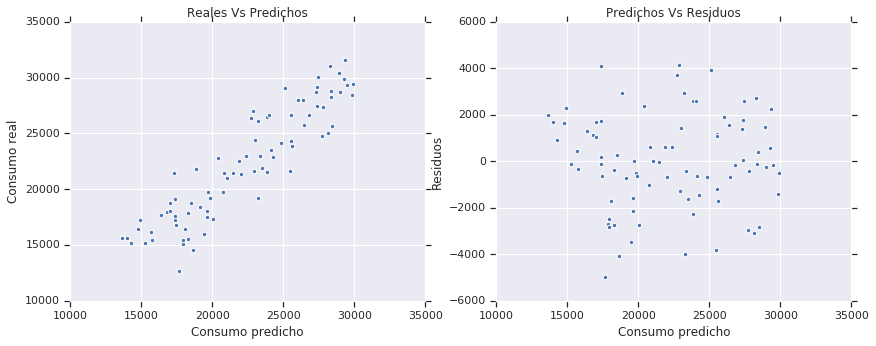

In [32]:
prect=reg_Month.predict();
residual=templ.Consumo-prect;
fig = plt.figure(figsize=(14,5))
plt.subplot2grid((1,2),(0,0))
plt.scatter(prect,templ.Consumo);
plt.title('Reales Vs Predichos');
plt.xlabel('Consumo predicho')
plt.ylabel('Consumo real')
plt.subplot2grid((1,2),(0,1))
plt.scatter(prect, residual);
plt.xlabel('Consumo predicho')
plt.ylabel('Residuos')
plt.title('Predichos Vs Residuos');

In [33]:
Resultado['Lineal']=Metricas(templ.Consumo, prect)
Resultado.head()

,Simple,Lineal
RMSE,2899.961046,2010.653140
MAE,2447.811765,1599.348828
Var_explain,0.664233,0.838588
R2,0.664228,0.838588


### SVR

In [34]:
from sklearn.svm import SVR
parameters = [{'kernel': ['rbf'], 'gamma': [1e5, 1e3, 1, 1e-3, 1e-5],
                     'C': [1, 10, 1e2, 1e3, 1e4]},
                    {'kernel': ['linear'], 'C': [1, 10, 1e2, 1e3, 2.3e3,1e4]}]
svc = SVR(gamma=0.01)
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train_scaled, templ["Consumo"])
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)
y=clf.predict(train_scaled)
Resultado['SVR']=Metricas(templ.Consumo, y)
Resultado.head()

Mejor configuración
----------------------------
C = 100.0
kernel = linear
Score = 0.734
SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


,Simple,Lineal,SVR
RMSE,2899.961046,2010.653140,2202.485875
MAE,2447.811765,1599.348828,1720.672974
Var_explain,0.664233,0.838588,0.806516
R2,0.664228,0.838588,0.806319


### ¿Como interpretar el resultado de las técnicas de machine learning?
Para las técnicas de machine learning aplicamos dos conceptos:
1. Selección optima de parametros: La cual consiste en probar un conjunto de parametros para crear modelos y extraer de todos ellos el de mejor resultado, a tráves del Score (Var_explain en nuestro caso)
2. Validación cruzada: Este proceso consiste en dividir el dataset de entrenamientos en varios subset del mismo, entrenando el modelo con n-1 subset y el subset faltante es usado para realizar *test* (obtener predicciones) al modelo entrenado, con el fin de corroborar que el modelo se ajuste a datos nunca visto.

En el apartado _'Mejor configuración'_ se registran los parametros seleccionados, en este caso C y kernel, y la configuación total del modelo. La parte importante de este análisis es que el valor "Score" representa el promedio de Var_explain de la validación cruzada; para esta prueba son 5 ejecuciones del modelo (cv=5)

La tabla de resultados nos muestra los valores para el mejor modelo entrenado con todos lo datos. La comparación entre el score de la validación cruzada y el R2 de la tabla, nos permite determinar si el modelo esta bien entrenado o no. El valor de Score no debe ser inferior a 0.3 con respecto al R2. Si esto ocurre es una clara señal de sobre entrenamientos con los datos totales.

### Arboles de decisión

In [35]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(max_depth=5)
regr.fit(train_scaled, templ["Consumo"])
y=regr.predict(train_scaled)
Resultado['Tree']=Metricas(templ["Consumo"], y)
Resultado.head()

,Simple,Lineal,SVR,Tree
RMSE,2899.961046,2010.653140,2202.485875,684.556888
MAE,2447.811765,1599.348828,1720.672974,464.917016
Var_explain,0.664233,0.838588,0.806516,0.981290
R2,0.664228,0.838588,0.806319,0.981290


In [36]:
parameters = [{'max_depth': [2,3,4,5,6,7,8,9]}]
regr = DecisionTreeRegressor()
clf = GridSearchCV(regr, parameters, cv=5)
clf.fit(train_scaled, templ["Consumo"])
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)
y=clf.predict(train_scaled)
Resultado['Tree']=Metricas(templ.Consumo, y)
Resultado.head()

Mejor configuración
----------------------------
max_depth = 4
Score = 0.777
DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


,Simple,Lineal,SVR,Tree
RMSE,2899.961046,2010.653140,2202.485875,978.593060
MAE,2447.811765,1599.348828,1720.672974,704.907283
Var_explain,0.664233,0.838588,0.806516,0.961765
R2,0.664228,0.838588,0.806319,0.961765


Este modelo es mejor que SVR y lineal, pero hay un salto de 0.2 entre el Score de la validación cruzada y los datos totales, con lo cual hay sospecha de sobre entrenamiento, pero por consevar un modelo con predicciones estables, se sigue manteniendo como mejor modelo el lineal.

### KNN

In [37]:
from sklearn.neighbors import KNeighborsRegressor

parameters = [{'n_neighbors': [2,3,5,7,9,12,15], 'leaf_size':[5,10,15,20,25,30,35,40], 'p':[1,2,3]}]
KNN = KNeighborsRegressor()
clf = GridSearchCV(KNN, parameters, cv=5)
clf.fit(train_scaled, templ["Consumo"])
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)
y=clf.predict(train_scaled)
Resultado['KNN']=Metricas(templ.Consumo, y)
Resultado.head()

Mejor configuración
----------------------------
n_neighbors = 5
p = 1
leaf_size = 5
Score = 0.826
KNeighborsRegressor(algorithm='auto', leaf_size=5, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=1,
          weights='uniform')


,Simple,Lineal,SVR,Tree,KNN
RMSE,2899.961046,2010.653140,2202.485875,978.593060,1811.881709
MAE,2447.811765,1599.348828,1720.672974,704.907283,1397.087059
Var_explain,0.664233,0.838588,0.806516,0.961765,0.869812
R2,0.664228,0.838588,0.806319,0.961765,0.868925


No tiene un mejor rendimiento que el modelo de árbol de decisión, pero es más estable para predeccir como se observa en la validación cruzada que arrojo 0.82 y 0.86 con todos los datos, valores muy similares. Dicho de otra forma, el modelo predice con la misma precisión tanto con porciones de datos que con todos ellos. Este es el mejor modelo hasta el momento.

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

parameters = [{'kernel':[1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.7),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=2.3)]}]
Gaus = GaussianProcessRegressor()
clf = GridSearchCV(Gaus, parameters, cv=5)
clf.fit(train_scaled, templ["Consumo"])
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)
y=clf.predict(train_scaled)
Resultado['Gaussian']=Metricas(templ.Consumo, y)
Resultado.head()

Mejor configuración
----------------------------
kernel = 1**2 * Matern(length_scale=1, nu=1.5)
Score = 0.673
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=1, nu=1.5),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)


,Simple,Lineal,SVR,Tree,KNN,Gaussian
RMSE,2899.961046,2010.653140,2202.485875,978.593060,1811.881709,2.045049e-11
MAE,2447.811765,1599.348828,1720.672974,704.907283,1397.087059,1.609271e-11
Var_explain,0.664233,0.838588,0.806516,0.961765,0.869812,1.000000e+00
R2,0.664228,0.838588,0.806319,0.961765,0.868925,1.000000e+00


El modelo gaussiano tiene un ajuste en la validación cruzada de 0.67 y al entrenarlo con todos los datos marca 1.00, por lo que se infiere que es un modelo sobre entrenado y queda descartado. Esto pudo ocurrir al no ser un modelo adecuado para este tipo de problemas. 

### Gradient boost

In [78]:
from sklearn.ensemble import GradientBoostingRegressor

parameters = [{'n_estimators': [20,50], 'min_samples_split':[5,10,15,20],
               'min_samples_leaf':[1,2,3,4,5,10,15,20], 'max_depth':[2,4,5,7,9],
               'loss':['ls', 'lad', 'huber', 'quantile']}]
est = GradientBoostingRegressor()
clf = GridSearchCV(est, parameters, cv=5)
clf.fit(train_scaled, templ["Consumo"])
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)
y=clf.predict(train_scaled)
Resultado['GrBoost']=Metricas(templ.Consumo, y)
Resultado.head()

Mejor configuración
----------------------------
max_depth = 4
loss = lad
min_samples_split = 10
n_estimators = 50
min_samples_leaf = 2
Score = 0.907
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=2,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


,Simple,Lineal,SVR,Tree,KNN,Gaussian,GrBoost
RMSE,2899.961046,2010.653140,2202.485875,978.593060,1811.881709,2.045049e-11,703.077866
MAE,2447.811765,1599.348828,1720.672974,704.907283,1397.087059,1.609271e-11,435.857305
Var_explain,0.664233,0.838588,0.806516,0.961765,0.869812,1.000000e+00,0.980412
R2,0.664228,0.838588,0.806319,0.961765,0.868925,1.000000e+00,0.980264


### Selección del mejor modelo

De acuerdo a esta tabla el mejor modelo es el __Gradient boost__ (GrBoost) debido a indice de correlación (R2=0.98) y la media de los errores menores al resto, además de tener valores cercanos en la validación cruzada (Score=0.9).

El modelo Gaussian fue descartado al no pasar el criterio de la validación cruzada, como se meciono en su repectivo apartado.

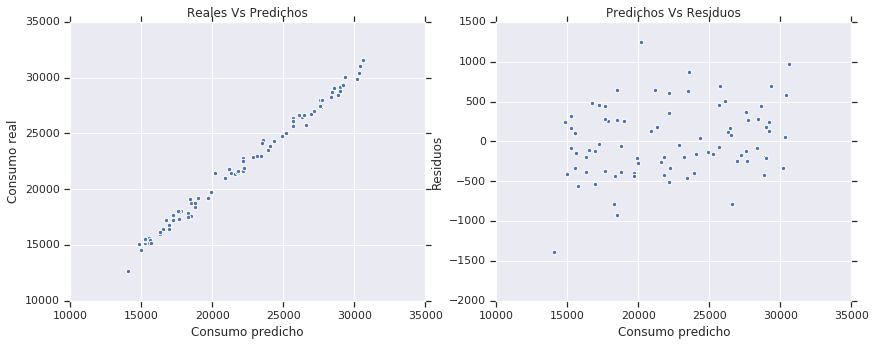

In [40]:
residual=templ.Consumo-y;
fig = plt.figure(figsize=(14,5))
plt.subplot2grid((1,2),(0,0))
plt.scatter(y,templ.Consumo);
plt.title('Reales Vs Predichos');
plt.xlabel('Consumo predicho')
plt.ylabel('Consumo real')
plt.subplot2grid((1,2),(0,1))
plt.scatter(y, residual);
plt.xlabel('Consumo predicho')
plt.ylabel('Residuos')
plt.title('Predichos Vs Residuos');

## Pronostico a 2 y 3 meses

Ahora se procede aplicar el modelo gradient boost en el resto de pronosticos

In [79]:
Mensual=pd.DataFrame(Metricas(templ.Consumo, y), columns=['Mes+1'],
                    index=['RMSE','MAE', 'Var_explain', 'R2']) #Almacena el resultado del modelo mensual previo
templ['Consumo']=templ['Consumo_1'].shift(-2);
templ=templ[:-2];
train_scaled = templ[["Tmedia","Tmin","Viento", "Presion", "Consumo_1", "Domingos", "Feriado", "Año", "Mes"]];
train_scaled.Consumo_1 = preprocessing.scale(train_scaled[["Consumo_1"]]).reshape(len(train_scaled));
train_scaled.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Tmedia,Tmin,Viento,Presion,Consumo_1,Domingos,Feriado,Año,Mes
Fecha,,,,,,,,,
1995-11-30,8,-2,30.0,1003.6,-0.958681,4,7,1995,11
1995-12-31,10,1,27.4,1004.5,-1.294930,5,8,1995,12
1996-01-31,9,1,25.8,1001.9,-1.297708,4,5,1996,1
1996-02-29,10,2,23.0,1001.4,-1.385840,4,4,1996,2
1996-03-31,9,1,24.3,998.8,-0.680592,5,5,1996,3


In [81]:
parameters = [{'n_estimators': [20,50], 'min_samples_split':[5,10,15,20],
               'min_samples_leaf':[1,2,3,4,5,10,15,20], 'max_depth':[2,4,5,7,9],
               'loss':['ls', 'lad', 'huber', 'quantile']}]
est = GradientBoostingRegressor()
clf = GridSearchCV(est, parameters, cv=5)
clf.fit(train_scaled, templ["Consumo"])
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)
y=clf.predict(train_scaled)
Mensual['Mes+2']=Metricas(templ.Consumo, y)

Mejor configuración
----------------------------
max_depth = 9
loss = huber
min_samples_split = 20
n_estimators = 50
min_samples_leaf = 4
Score = 0.933
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=9,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=4, min_samples_split=20,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)


In [82]:
templ['Consumo']=templ['Consumo_1'].shift(-3)
templ=templ[:-3]
templ.head()
train_scaled = templ[["Tmedia","Tmin","Viento", "Presion", "Consumo_1", "Domingos", "Feriado", "Año", "Mes"]]
train_scaled.Consumo_1 = preprocessing.scale(train_scaled[["Consumo_1"]]).reshape(len(train_scaled))
train_scaled.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Tmedia,Tmin,Viento,Presion,Consumo_1,Domingos,Feriado,Año,Mes
Fecha,,,,,,,,,
1995-11-30,8,-2,30.0,1003.6,-0.924793,4,7,1995,11
1995-12-31,10,1,27.4,1004.5,-1.265268,5,8,1995,12
1996-01-31,9,1,25.8,1001.9,-1.268082,4,5,1996,1
1996-02-29,10,2,23.0,1001.4,-1.357321,4,4,1996,2
1996-03-31,9,1,24.3,998.8,-0.643207,5,5,1996,3


In [83]:
parameters = [{'n_estimators': [20,50], 'min_samples_split':[5,10,15,20],
               'min_samples_leaf':[1,2,3,4,5,10,15,20], 'max_depth':[2,4,5,7,9],
               'loss':['ls', 'lad', 'huber', 'quantile']}]
est = GradientBoostingRegressor()
clf = GridSearchCV(est, parameters, cv=5)
clf.fit(train_scaled, templ["Consumo"])
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)
y=clf.predict(train_scaled)
Mensual['Mes+3']=Metricas(templ.Consumo, y)

Mejor configuración
----------------------------
max_depth = 9
loss = ls
min_samples_split = 20
n_estimators = 50
min_samples_leaf = 4
Score = 0.925
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=9, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=4,
             min_samples_split=20, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [84]:
Mensual

,Mes+1,Mes+2,Mes+3
RMSE,703.077866,479.759230,422.962322
MAE,435.857305,295.669446,302.468196
Var_explain,0.980412,0.990695,0.992823
R2,0.980264,0.990689,0.992823


Todos los pronosticos tienen una relación 99% y errores inferiores a 500.

## Predicción Semanal

Al igual que con la serie mensual se deben agrupar los datos por semana. Debido a que los datos inician un jueves, la semana inicia este día (para perder la menor catidad de datos). No se calculan la cantidad de domingos puesto que siempre habrá un domingo en una semana completa.

Se realizo un modelo semana por semana para evidenciar los cambios entre los parametros optimos de los modelos (a pesar de usar el mismo tipo de técnica y explorar los mismos parametros)

In [46]:
datos=datos.set_index(datos['Fecha'])
datos.head()
Week=datos.resample('W-Thu').sum()
Week.Mes=Week.index.month
Week.Año=Week.index.year

temp=temp.drop(columns=['Feriado', 'Domingos', 'Consumo'])
train=pd.merge(Week, temp, on=['Mes', 'Año'])
train.head()

,Consumo,Dia,Mes,Año,Feriado,Tmedia,Tmax,Tmin,Viento,Vmax,Presion,Lluvia
0,4113,148,11,1995,3,8,18,-2,30.0,114.8,1003.6,20.5
1,4542,42,11,1995,2,8,18,-2,30.0,114.8,1003.6,20.5
2,3700,91,11,1995,1,8,18,-2,30.0,114.8,1003.6,20.5
3,3727,140,11,1995,2,8,18,-2,30.0,114.8,1003.6,20.5
4,4143,189,11,1995,1,8,18,-2,30.0,114.8,1003.6,20.5


In [47]:
train_=train.copy(deep=True)
train_=train_.rename(columns = {'Consumo':'Consumo_1'})
train_['Consumo']=train_['Consumo_1'].shift(-1)
train_=train_[:-1]
train_.head()

,Consumo_1,Dia,Mes,Año,Feriado,Tmedia,Tmax,Tmin,Viento,Vmax,Presion,Lluvia,Consumo
0,4113,148,11,1995,3,8,18,-2,30.0,114.8,1003.6,20.5,4542.0
1,4542,42,11,1995,2,8,18,-2,30.0,114.8,1003.6,20.5,3700.0
2,3700,91,11,1995,1,8,18,-2,30.0,114.8,1003.6,20.5,3727.0
3,3727,140,11,1995,2,8,18,-2,30.0,114.8,1003.6,20.5,4143.0
4,4143,189,11,1995,1,8,18,-2,30.0,114.8,1003.6,20.5,3845.0


In [48]:
Consumo=train_.Consumo
train_scaled = train_[["Tmedia","Tmin","Viento", "Presion", "Consumo_1", "Feriado", "Año", "Mes"]]
train_scaled.Consumo_1 = preprocessing.scale(train_scaled[["Consumo_1"]]).reshape(len(train_scaled))
train_scaled.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Tmedia,Tmin,Viento,Presion,Consumo_1,Feriado,Año,Mes
0,8,-2,30.0,1003.6,-0.846386,3,1995,11
1,8,-2,30.0,1003.6,-0.473266,2,1995,11
2,8,-2,30.0,1003.6,-1.205590,1,1995,11
3,8,-2,30.0,1003.6,-1.182107,2,1995,11
4,8,-2,30.0,1003.6,-0.820294,1,1995,11


#### Una Semana

In [49]:
parameters = [{'n_estimators': [20,50], 'min_samples_split':[5,10,15,20],
               'min_samples_leaf':[1,2,3,4,5,10,15,20], 'max_depth':[2,4,5,7,9],
               'loss':['ls', 'lad', 'huber', 'quantile']}]
est = GradientBoostingRegressor()
clf = GridSearchCV(est, parameters, cv=5)
clf.fit(train_scaled, Consumo)
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)
y=clf.predict(train_scaled)
Semanal=pd.DataFrame(Metricas(Consumo, y),columns=['Sem+1'], index=['RMSE','MAE', 'Var_explain', 'R2'])

Mejor configuración
----------------------------
max_depth = 2
loss = lad
min_samples_split = 15
n_estimators = 50
min_samples_leaf = 20
Score = 0.889
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=20,
             min_samples_split=15, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


#### Dos semanas

In [50]:
train_=train.copy(deep=True)
train_=train_.rename(columns = {'Consumo':'Consumo_1'})
train_['Consumo']=train_['Consumo_1'].shift(-2)
train_=train_[:-2];
Consumo=train_.Consumo;
train_scaled = train_[["Tmedia","Tmin","Viento", "Presion", "Consumo_1", "Feriado", "Año", "Mes"]];
train_scaled.Consumo_1 = preprocessing.scale(train_scaled[["Consumo_1"]]).reshape(len(train_scaled));

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [51]:
parameters = [{'n_estimators': [20,50], 'min_samples_split':[5,10,15,20],
               'min_samples_leaf':[1,2,3,4,5,10,15,20], 'max_depth':[2,4,5,7,9],
               'loss':['ls', 'lad', 'huber', 'quantile']}]
est = GradientBoostingRegressor()
clf = GridSearchCV(est, parameters, cv=5)
clf.fit(train_scaled, Consumo)
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)
y=clf.predict(train_scaled)
Semanal["Sem+2"]=Metricas(Consumo, y)

Mejor configuración
----------------------------
max_depth = 7
loss = huber
min_samples_split = 5
n_estimators = 50
min_samples_leaf = 20
Score = 0.874
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=7,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=20, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)


#### Tres semanas

In [52]:
train_=train.copy(deep=True)
train_=train_.rename(columns = {'Consumo':'Consumo_1'})
train_['Consumo']=train_['Consumo_1'].shift(-3)
train_=train_[:-3]
Consumo=train_.Consumo
train_scaled = train_[["Tmedia","Tmin","Viento", "Presion", "Consumo_1", "Feriado", "Año", "Mes"]]
train_scaled.Consumo_1 = preprocessing.scale(train_scaled[["Consumo_1"]]).reshape(len(train_scaled))

parameters = [{'n_estimators': [20,50], 'min_samples_split':[5,10,15,20],
               'min_samples_leaf':[5,10,15,20], 'max_depth':[2,4,5,7,9],
               'loss':['ls', 'lad', 'huber', 'quantile']}]
est = GradientBoostingRegressor()
clf = GridSearchCV(est, parameters, cv=5)
clf.fit(train_scaled, Consumo)
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)
y=clf.predict(train_scaled)
Semanal["Sem+3"]=Metricas(Consumo, y)

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Mejor configuración
----------------------------
max_depth = 4
loss = lad
min_samples_split = 5
n_estimators = 50
min_samples_leaf = 15
Score = 0.857
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=15,
             min_samples_split=5, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


#### Cuatro semanas

In [53]:
train_=train.copy(deep=True)
train_=train_.rename(columns = {'Consumo':'Consumo_1'})
train_['Consumo']=train_['Consumo_1'].shift(-4)
train_=train_[:-4]
Consumo=train_.Consumo
train_scaled = train_[["Tmedia","Tmin","Viento", "Presion", "Consumo_1", "Feriado", "Año", "Mes"]]
train_scaled.Consumo_1 = preprocessing.scale(train_scaled[["Consumo_1"]]).reshape(len(train_scaled))

parameters = [{'n_estimators': [20,50], 'min_samples_split':[5,10,15,20],
               'min_samples_leaf':[5,10,15,20], 'max_depth':[2,4,5,7,9],
               'loss':['ls', 'lad', 'huber', 'quantile']}]
est = GradientBoostingRegressor()
clf = GridSearchCV(est, parameters, cv=5)
clf.fit(train_scaled, Consumo)
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)
y=clf.predict(train_scaled)
Semanal["Sem+4"]=Metricas(Consumo, y)

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Mejor configuración
----------------------------
max_depth = 9
loss = lad
min_samples_split = 10
n_estimators = 50
min_samples_leaf = 20
Score = 0.851
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=9, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=20,
             min_samples_split=10, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


#### Cinco Semanas

In [55]:
train_=train.copy(deep=True)
train_=train_.rename(columns = {'Consumo':'Consumo_1'});
train_['Consumo']=train_['Consumo_1'].shift(-5);
train_=train_[:-5];
Consumo=train_.Consumo
train_scaled = train_[["Tmedia","Tmin","Viento", "Presion", "Consumo_1", "Feriado", "Año", "Mes"]];
train_scaled.Consumo_1 = preprocessing.scale(train_scaled[["Consumo_1"]]).reshape(len(train_scaled));

parameters = [{'n_estimators': [20,50], 'min_samples_split':[5,10,15,20],
               'min_samples_leaf':[5,10,15,20], 'max_depth':[2,4,5,7,9],
               'loss':['ls', 'lad', 'huber', 'quantile']}]
est = GradientBoostingRegressor(random_state=0)
clf = GridSearchCV(est, parameters, cv=5)
clf.fit(train_scaled, Consumo)
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)
y=clf.predict(train_scaled)
Semanal["Sem+5"]=Metricas(Consumo, y)

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Mejor configuración
----------------------------
max_depth = 4
loss = huber
min_samples_split = 5
n_estimators = 50
min_samples_leaf = 15
Score = 0.850
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=0, subsample=1.0, verbose=0, warm_start=False)


#### Resultado de los pronosticos

In [56]:
Semanal

,Sem+1,Sem+2,Sem+3,Sem+4,Sem+5
RMSE,313.951203,261.475663,303.518224,292.305347,279.704660
MAE,241.337774,202.250934,220.751210,213.207835,220.919626
Var_explain,0.925844,0.948488,0.930617,0.935518,0.940962
R2,0.925568,0.948478,0.930493,0.935463,0.940958


## Pronóstico diario

Utilizamos los datos diarios, clasificando los días de la semana en tres grupos Sábados, domingos y el resto de días.

Para el modelo se utiliza un procedimiento más simplificado y más fácil de visualizar, el cual consiste en encapsular _n_ modelos como variables a predecir existan (en este caso 7) por medio de la función *MultiOutputRegressor* . Esto permite entrenar los *n* modelos al 'tiempo' pero todos tendrán la misma configuración. Como se evidenció en el pronóstico semanal, los modelos no siempre tienen la misma configuración para alcanzar una predicción optima.

In [57]:
datos=datos.set_index(datos['Fecha'])

train=pd.merge(datos, temp, on=['Mes', 'Año']) #Une los datos de clima
Consumo=pd.DataFrame(train.Consumo) #Crea la serie para pronostica donde t_n=t+n (siendo n el #días)
Consumo["t_1"]=Consumo['Consumo'].shift(-1)
Consumo["t_2"]=Consumo['Consumo'].shift(-2)
Consumo["t_3"]=Consumo['Consumo'].shift(-3)
Consumo["t_4"]=Consumo['Consumo'].shift(-4)
Consumo["t_5"]=Consumo['Consumo'].shift(-5)
Consumo["t_6"]=Consumo['Consumo'].shift(-6)
Consumo["t_7"]=Consumo['Consumo'].shift(-7)
Consumo=Consumo[:-7] #Elimina los registros con NA
Consumo=Consumo.drop(columns=['Consumo']) #Elimina la columna Consumo para el día t

train=train[:-7] #Elimina los registros que no tienen variable a pronosticar
#Codificación de los días de la semana

train.loc[(train.DiaSemana != 'Sábado') & (train.DiaSemana != 'Domingo'), 'DiaSemana'] = 0
train.loc[train.DiaSemana == 'Sábado', 'DiaSemana'] = 1
train.loc[train.DiaSemana == 'Domingo', 'DiaSemana'] = 2
train.Consumo = preprocessing.scale(train[["Consumo"]]).reshape(len(train))
train=train.drop(columns=['Dia','Lluvia','Vmax','Tmax','Fecha'])
train.head()

,Consumo,Mes,Año,DiaSemana,Feriado,Tmedia,Tmin,Viento,Presion
0,-0.939959,11,1995,0,1,8,-2,30.0,1003.6
1,-0.311515,11,1995,0,0,8,-2,30.0,1003.6
2,-0.392980,11,1995,0,0,8,-2,30.0,1003.6
3,-0.550091,11,1995,1,0,8,-2,30.0,1003.6
4,-1.143622,11,1995,2,1,8,-2,30.0,1003.6


In [58]:
from sklearn.multioutput import MultiOutputRegressor

parameters = [{'estimator__n_estimators': [20,50], 'estimator__min_samples_split':[5,10,15,20],
               'estimator__min_samples_leaf':[5,10,15,20], 'estimator__max_depth':[2,4,5,7,9],
               'estimator__loss':['ls', 'lad', 'huber', 'quantile']}]

est = GradientBoostingRegressor(random_state=0)
clf = GridSearchCV(MultiOutputRegressor(est), param_grid=parameters, cv=5)
clf.fit(train, Consumo)
print("Mejor configuración")
print("----------------------------")
for i in clf.best_params_:
    print(i+" = "+str(clf.best_params_[i]))
print("Score = %4.3f"% clf.best_score_)
print(clf.best_estimator_)

Mejor configuración
----------------------------
estimator__n_estimators = 50
estimator__max_depth = 4
estimator__min_samples_split = 5
estimator__min_samples_leaf = 15
estimator__loss = huber
Score = 0.825
MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=0, subsample=1.0, verbose=0, warm_start=False),
           n_jobs=1)


In [59]:
y=clf.predict(train)
Diario=pd.DataFrame(Metricas(Consumo['t_1'], y[:,0]),columns=['Dia+1'], index=['RMSE','MAE', 'Var_explain', 'R2'])
Diario["Dia+2"]=Metricas(Consumo['t_2'], y[:,1])
Diario["Dia+3"]=Metricas(Consumo['t_3'], y[:,2])
Diario["Dia+4"]=Metricas(Consumo['t_4'], y[:,3])
Diario["Dia+5"]=Metricas(Consumo['t_5'], y[:,4])
Diario["Dia+6"]=Metricas(Consumo['t_6'], y[:,5])
Diario["Dia+7"]=Metricas(Consumo['t_7'], y[:,6])
Diario

,Dia+1,Dia+2,Dia+3,Dia+4,Dia+5,Dia+6,Dia+7
RMSE,44.443785,56.728943,58.969145,60.924252,61.464510,62.337548,58.200631
MAE,34.266004,44.347715,46.496055,48.192537,48.670060,49.423671,46.238421
Var_explain,0.933144,0.891126,0.882359,0.874480,0.872279,0.868691,0.885606
R2,0.933144,0.891126,0.882356,0.874479,0.872278,0.868690,0.885600
